# Evaluating the power of classification directly from the SOM clustering

In [18]:
import os
import json
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_curve


In [5]:
filename_clusters = "som_iqa_loaded_results_5_clusters.parquet"
filename_mapping = "fits_objects_mapping_2.parquet.gz"
filename_labels = "map_images_labels_2.json"

data_path = "/home/mike/git/computational_astro/astro_iqa/data/"
file_path = os.path.join(data_path, "for_modeling")

In [3]:
# Reading clusters from the parquet file
print(f"Reading clusters from {os.path.join(file_path, filename_clusters)}")
clusters = pd.read_parquet(os.path.join(file_path, "Results", filename_clusters))
clusters = clusters.reset_index().rename(columns={'index': 'OBJECT_ID'})

# Reading fits / ground truth labels
print(f"Reading ground truth labels from {os.path.join(file_path, filename_labels)}")
with open(os.path.join(file_path, filename_labels), 'r') as f:
    labels_gt = json.load(f)


Reading clusters from /home/mike/git/computational_astro/astro_iqa/data/for_modeling/som_iqa_loaded_results_5_clusters.parquet
Reading ground truth labels from /home/mike/git/computational_astro/astro_iqa/data/for_modeling/map_images_labels_2.json


In [6]:
# Reading fits / object mapping
mapping_fits_obj = pd.read_parquet(os.path.join(file_path, filename_mapping), engine='auto')

In [7]:
# Transform into a dictionary in order to get columns
annotations_dict = {
    "Image_id": list(labels_gt["annotations"].keys()),
    "Label": list(labels_gt["annotations"].values())
}

annotations = pd.DataFrame(annotations_dict)

# A few corrections
# split multiple labels into separate columns
annotations[['Label1', 'Label2']] = annotations['Label'].str.split(', ', expand=True)
# Delete the original column
annotations = annotations.drop(columns=['Label'])
# Add a p to the Image_id column
annotations['Image_id'] = annotations['Image_id'].astype(str) + 'p'

print(labels_gt["categories"])

['GOOD', 'B_SEEING', 'BGP', 'BT', 'RBT']


In [8]:
# Encode ground truth labels
label_encoder = LabelEncoder()
label_encoder.fit(labels_gt["categories"])
print(label_encoder.classes_)
print(label_encoder.transform(labels_gt["categories"]))
print(label_encoder.transform(annotations[1:5]['Label1']))

['BGP' 'BT' 'B_SEEING' 'GOOD' 'RBT']
[3 2 0 1 4]
[0 3 3 3]


In [9]:
mapping_fits_obj["CLUSTER_ID"] = clusters.loc[clusters["OBJECT_ID"].isin(mapping_fits_obj["OBJECT_ID"]), "5_clusters"]

<Axes: >

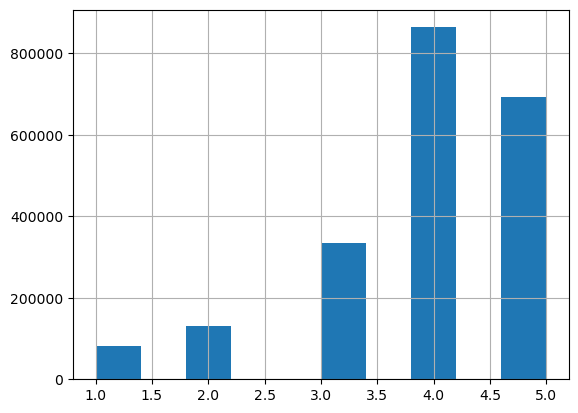

In [10]:
mapping_fits_obj["CLUSTER_ID"].hist()

<Axes: >

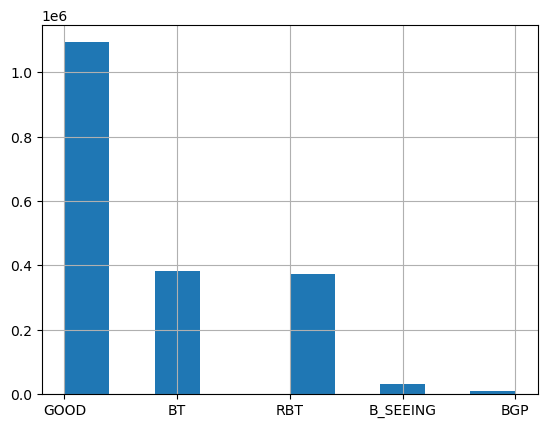

In [11]:
mapping_fits_obj["gt_label1"].hist()

## Measuring performances of the SOM clustering

### With the categories as defined in the label file


y_pred: min = 1, max = 5
['BGP' 'BT' 'B_SEEING' 'GOOD' 'RBT']


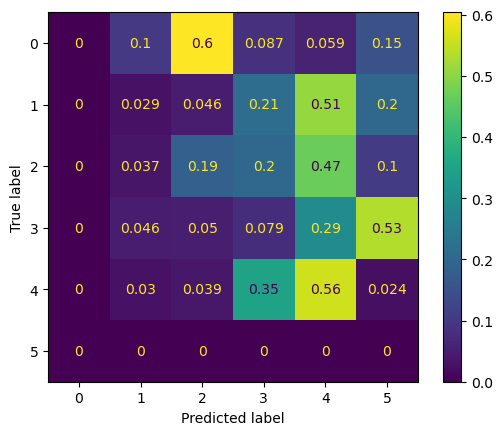

In [25]:
# Filter out rows with None in gt_label1
filtered_mapping_fits_obj = mapping_fits_obj[mapping_fits_obj["gt_label1"].notna()]

y_gt = label_encoder.transform(filtered_mapping_fits_obj["gt_label1"])
y_pred = clusters.loc[clusters["OBJECT_ID"].isin(filtered_mapping_fits_obj["OBJECT_ID"]), "5_clusters"]
print("y_pred: min = {}, max = {}".format(y_pred.min(), y_pred.max()))
cm = confusion_matrix(y_gt, y_pred, normalize='true')

print(label_encoder.classes_)           
cm_display = ConfusionMatrixDisplay(cm).plot()

In [22]:

print(np.sum(cm, axis=1))

[1. 1. 1. 1. 1. 0.]


The confusion matrix shows:
- a pretty good power of predicting good images through the cluster 5 and seems to show a good power of separating the good images from the bad ones. As the confusion matrix is normalised against the true labels, we can trust that this separation power is not only due to a higher representation of the good images in the dataset. We can confidently think that the features used for the clustering are relevant to separate the good images from the bad ones.
- the BGP class seems to be well separated from the other classes. With a good prediction power for the cluster 2.
- the other classes BT, B_SEEING and RBT are not well separated by the cluster. They all find their best score in the cluster 4. This might be due to the fact that the image samples for B_SEEING are very few (only 2 files, ie 32 images) and good representative samples of this class are difficult to find in the enormous source database with no annotations on the image quality. The example of the observation 1853401p given in the original publication shows a small background issue with not much blurring issues of edges for the brightest objects in the image. So might be difficult to characterise an differentiate from a good image. In addition, it also shows some small tracking issues. The image samples for the class BT show small back tracking issues that might be difficult to characterise and differentiate from good samples.

In conclusion, the cluster analysis shows a potential of prediction good / not good images.
We forsee a lack of prediction power for other classes probably due to the lack of representative samples in the dataset for these classes.
Finding good samples in the source [database](http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/search/) represents a challenge as there are no annotations on the image quality, and the authors of the original publication didn't share his dataset or provided the annotations used for the training of the SOM.
